In [281]:
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np 
import os
import math

Funcition turns all .jpg files into bitmap format:

In [282]:
def cutThirdDimension(bitmap):
    if bitmap.ndim == 3:
        return bitmap[..., 0]
    else:
        return bitmap

In [283]:
def scaleBitmap(bitmap):
    return bitmap/255.0

In [284]:
def turnJpgIntoBitmap(directory):  
    bitmap_files = []
    jpg_files = [os.path.join(directory, file) for file in os.listdir(directory) if file.lower().endswith('.jpg')]
    for file in jpg_files:
        img = Image.open(file)
        bitmap = np.array(img)
        bitmap_files.append(scaleBitmap(cutThirdDimension(bitmap)))
    return bitmap_files

In [285]:
def turnSingleJpgIntoBitmap(single_file):
    directory = r"Tomograf-images"
    jpg_file = os.path.join(directory, single_file)
    if single_file.lower().endswith('.jpg'):
        img = Image.open(jpg_file)
        bitmap = np.array(img)
        return scaleBitmap(cutThirdDimension(bitmap))
    else:
        print('Wrong file format')
        exit()
    

In [286]:
def bresenhamAlgorithm(x1, y1, x2, y2):
    points = []
    x = x1
    y = y1
    dx = abs(x2 - x1)
    dy = abs(y2 - y1)

    # Direction of the algorithm
    xi = 1 if x1 < x2 else -1
    yi = 1 if y1 < y2 else -1

    # First pixel
    points.append((x,y))

    if dx > dy:
        # Algorithm operates on the leading axis OX
        
        d = 2*dy - dx
        while x != x2:
            # Incrementing D according to algorithm
            if d >= 0:
                # Move diagonally
                x += xi
                y += yi
                d += 2*(dy-dx)
            else:
                # Move horizzontally
                d += 2*dy
                x += xi
            points.append((x,y))
    else:
        # Algorithm operates on the leading axis OY

        d = 2*dx - dy
        while y != y2:
            # Incrementing D according to algorithm
            if d >= 0:
                # Move diagonally
                x += xi
                y += yi
                d += 2*(dx-dy)
            else:
                # Move vertically
                d += 2*dx
                y += yi
            points.append((x,y))
    return points

In [ ]:
def generateRays(bitmap , step, detectors_span, detectors_number):
    size = max(bitmap.shape)
    matrix = np.zeros((size,size))
    
    center = size//2
    radius = size//2 - 1
    angles = np.arange(0,180.1,step)

    span_rad = math.radians(detectors_span)

    for angle in angles:
        rad = math.radians(angle)

        # Emitter coordinates
        x = int(center + radius*math.cos(rad))
        y = int(center + radius*math.sin(rad))

        # Visualize emitter
        if 0 <= x < size and 0 <= y < size:
            matrix[x][y] = 1.0

        # Calculate detectors placements for each emiiter 
        for i in range(detectors_number):
            # Detector coordinates
            x_d = int(center + radius*math.cos(rad + math.pi - span_rad/2 + (i*span_rad)/(detectors_number-1)))
            y_d = int(center + radius*math.sin(rad + math.pi - span_rad/2 + (i*span_rad)/(detectors_number-1)))

            # Ray between emitter and detector
            bresenham_points = bresenhamAlgorithm(x, y, x_d, y_d)

            # Visualize rays between emitter and detector
            for x_b, y_b in bresenham_points:
                if 0 <= x_b < size and 0 <= y_b < size:
                    matrix[x_b][y_b] = 1.0
        

    return matrix

In [288]:
def RadonTransform(bitmap):
    pass

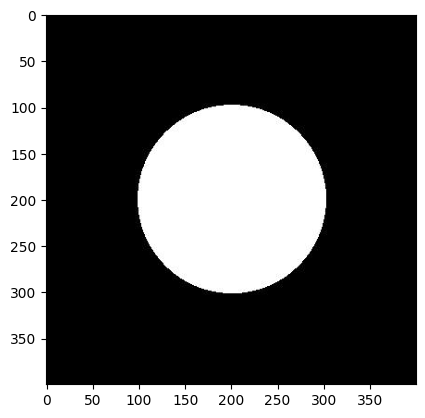

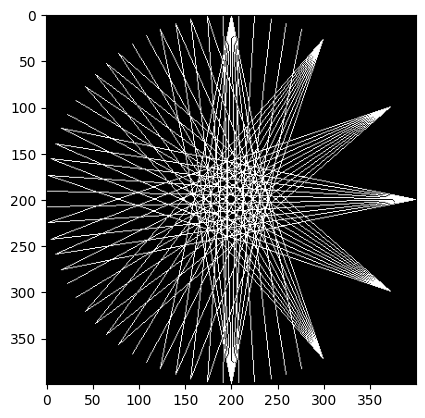

In [ ]:
if __name__ == '__main__':
    #For multiple files turning into bitmaps
    # bitmap_files = turnJpgIntoBitmap(r"Tomograf-images")
    # for file in bitmap_files:
    #     plt.imshow(file, cmap='gray')
    #     plt.show()

    #Single file into bitmap
    bitmap = turnSingleJpgIntoBitmap('kolo.jpg')
    plt.imshow(bitmap, cmap='gray')
    plt.show()

    # Generate rays
    matrix = generateRays(bitmap=bitmap, step=30, detectors_span=45, detectors_number=10)
    plt.imshow(matrix, cmap='gray')
    plt.show()
    

    

    